In [37]:
# Importing the required libraries
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model
from keras.models import Model
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Dropout, \
BatchNormalization, Flatten, SpatialDropout1D, GRU
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Loading the data
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# ***Exploratory Data Analysis***

In [3]:
df.shape

(14640, 15)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [ ]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

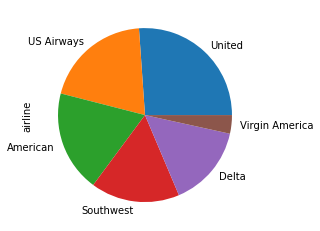

In [ ]:
df.airline.value_counts().plot(kind='pie')

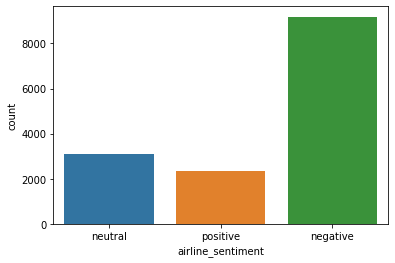

In [ ]:
sns.countplot(x='airline_sentiment',data=df)

Total number of tweets for each airline 
  airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


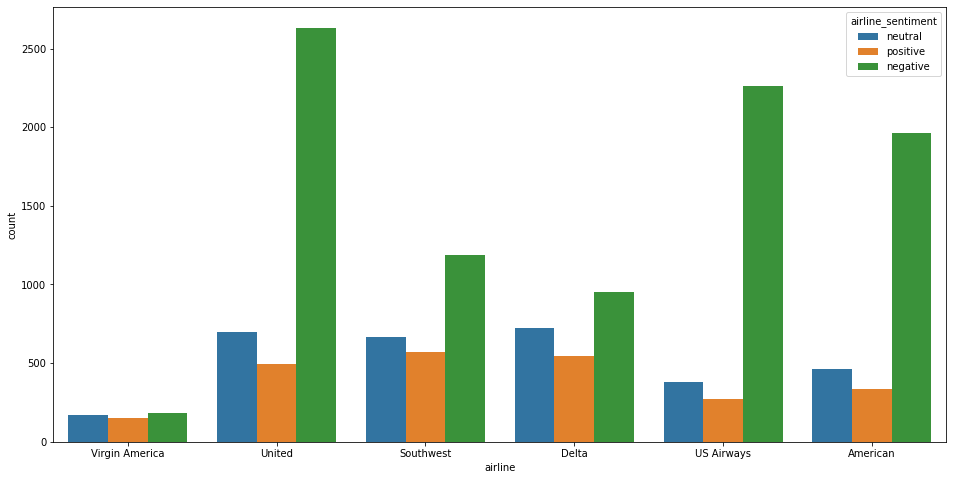

In [ ]:
print("Total number of tweets for each airline \n ",df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
plt.figure(figsize=(16,8))
sns.countplot(x='airline',hue='airline_sentiment',data=df)

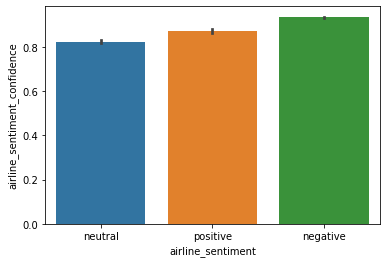

In [ ]:
sns.barplot(x='airline_sentiment',y='airline_sentiment_confidence',data=df)

Neagtive sentiment reasons
 [nan 'Bad Flight' "Can't Tell" 'Late Flight' 'Customer Service Issue'
 'Flight Booking Problems' 'Lost Luggage' 'Flight Attendant Complaints'
 'Cancelled Flight' 'Damaged Luggage' 'longlines']


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

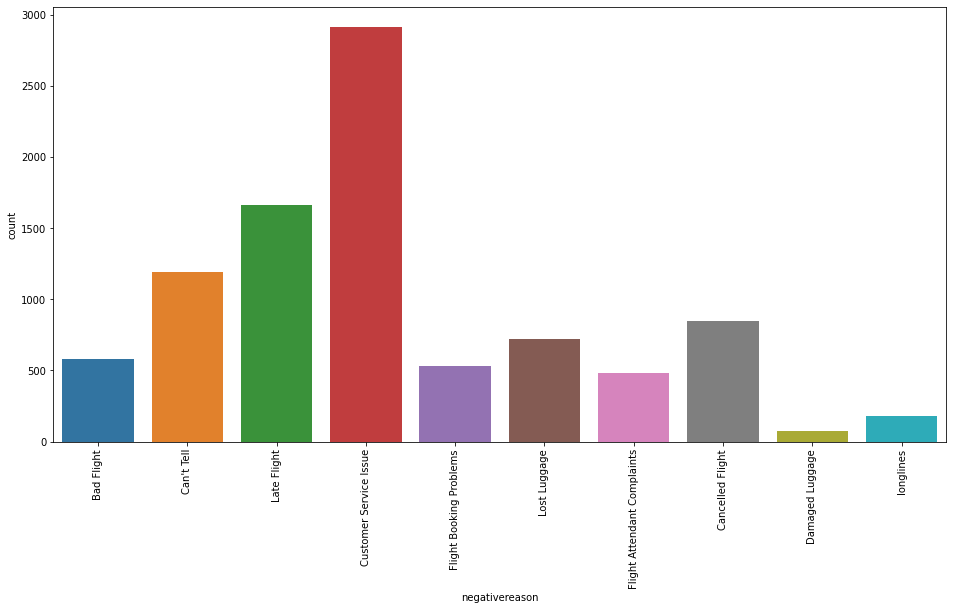

In [ ]:
print("Neagtive sentiment reasons\n", df['negativereason'].unique())
plt.figure(figsize=(16,8))
neg_reasons_plot = sns.countplot(x='negativereason', data=df)
plt.xticks(rotation=90)

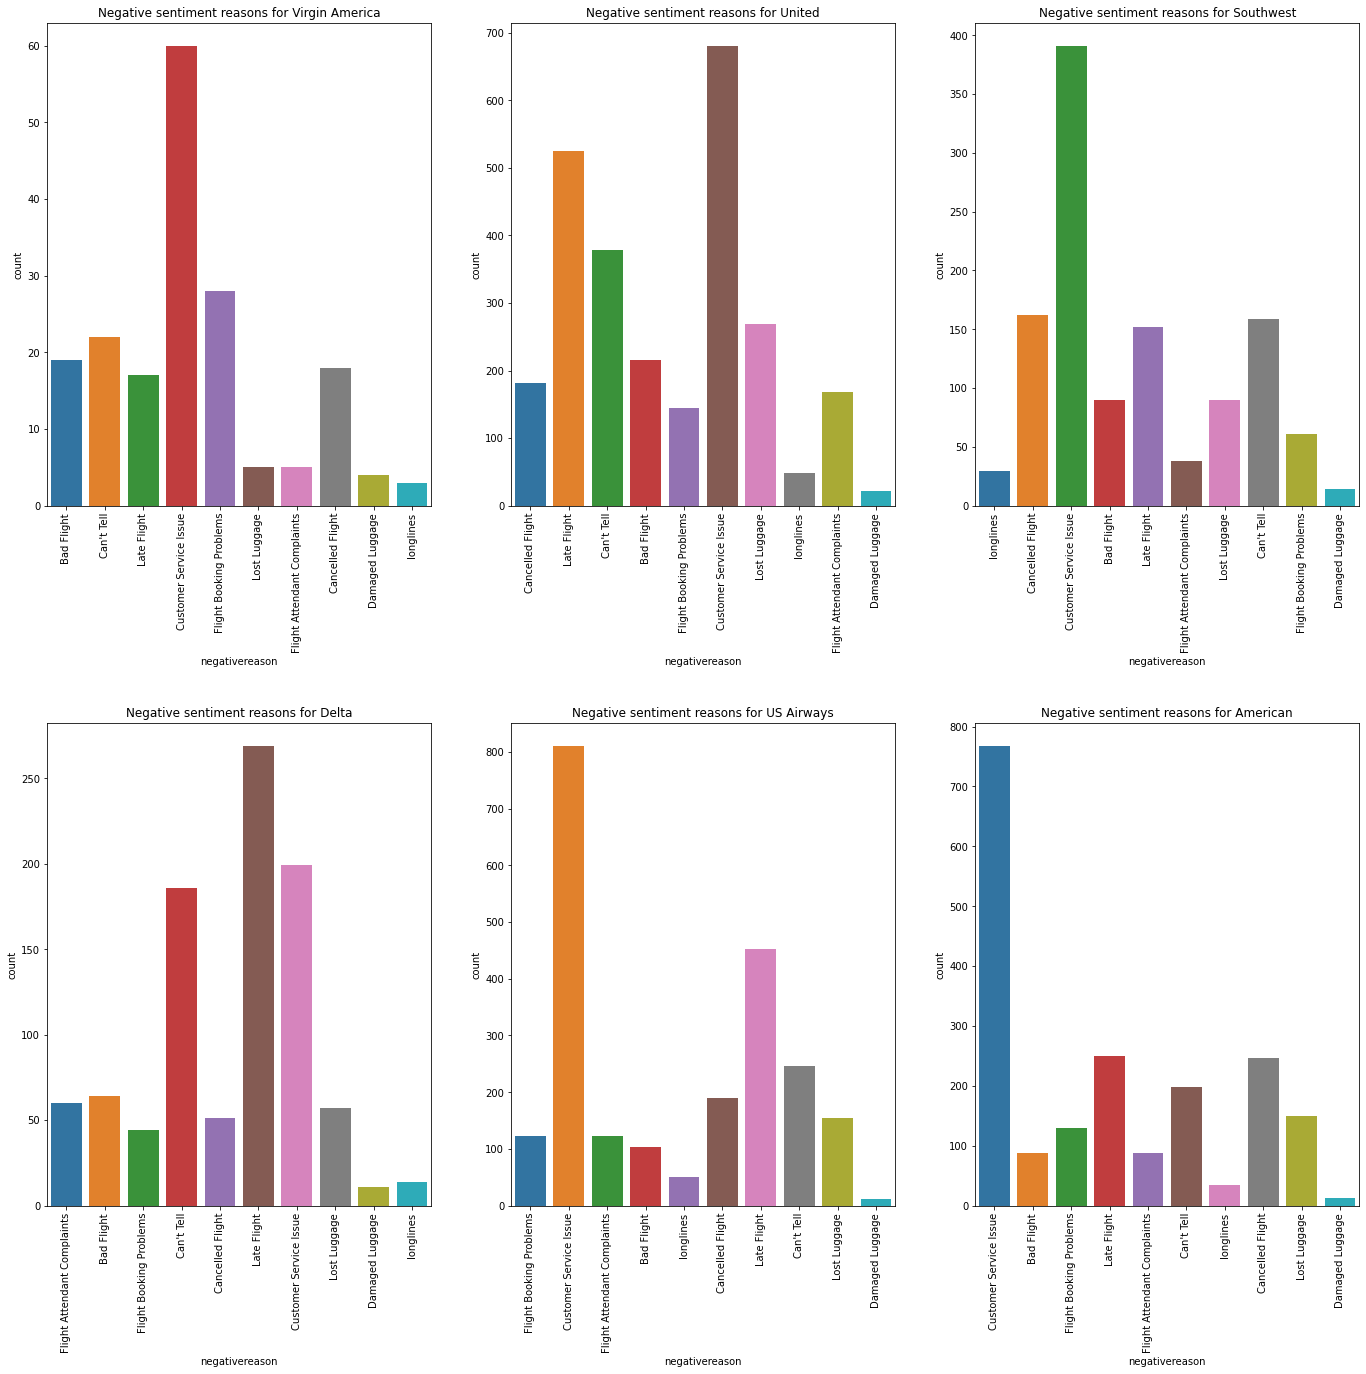

In [ ]:
def plot_neg_reasons(airline_name):
  new_df = df[df['airline'] == airline_name]
  reasons_df = new_df[['airline', 'negativereason']]
  sns.countplot(x='negativereason', data=reasons_df)
  plt.xticks(rotation=90)

airlines = list(df['airline'].unique())
plt.figure(figsize=(20,20))

for i in range(len(airlines)):
  plt.subplot(2,3,i+1)
  plt.title(f"Negative sentiment reasons for {airlines[i]}")
  plt.tight_layout(pad=4)
  plot_neg_reasons(airlines[i])

In [ ]:
print(f"Tweets from {len(pd.to_datetime(df['tweet_created']).dt.date.unique())} distinct dates are present in dataset")

Tweets from 9 distinct dates are present in dataset


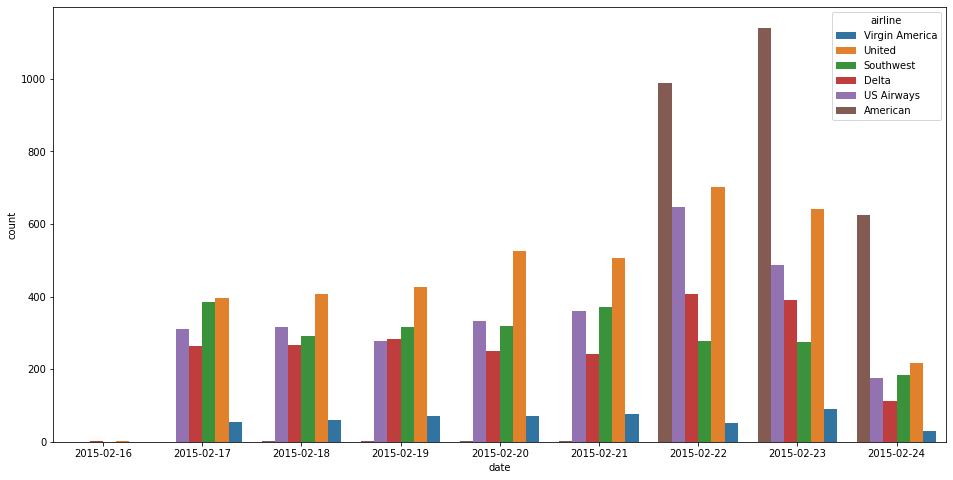

In [ ]:
new_df = df.loc[:,['airline', 'airline_sentiment']]
new_df['date'] = pd.to_datetime(df['tweet_created']).dt.date
plt.figure(figsize=(16,8))
date_plot = sns.countplot(x='date',hue='airline',data=new_df)
date_plot.invert_xaxis()

In [ ]:
print("Percentage null or na values in df")
print(((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2))

Percentage null or na values in df
tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64


In [4]:
del df['tweet_coord']
del df['airline_sentiment_gold']
del df['negativereason_gold']
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# ***Preprocessing the data***

In [5]:
def clean_tweet(tweet):
  without_mentions = " ".join(filter(lambda x:x[0]!='@', tweet.split()))
  letters_only = re.sub("[^a-zA-Z]", " ",without_mentions) 
  words = letters_only.lower().split()    
  stops = set(stopwords.words("english"))                  
  meaningful_words = [w for w in words if not w in stops and len(w) > 2] 
  lemmatizer = WordNetLemmatizer()
  lemmas = [lemmatizer.lemmatize(word) for word in meaningful_words]
  return " ".join(lemmas)

df['clean_tweet']=df['text'].apply(lambda x: clean_tweet(x))
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,clean_tweet
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),said
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus added commercial experience tacky
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),today must mean need take another trip
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),really aggressive blast obnoxious entertainmen...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),really big bad thing


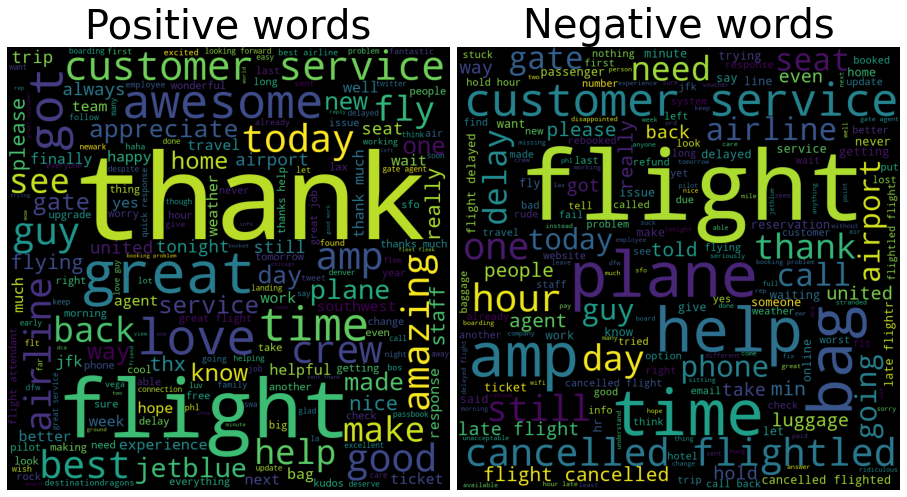

In [ ]:
new_df = df[df['airline_sentiment']=='positive']
words = ' '.join(new_df['clean_tweet'])
positive_words = " ".join([word for word in words.split()
                            if 'http' not in word
                                and word != 'RT'
                            ])

new_df = df[df['airline_sentiment']=='negative']
words = ' '.join(new_df['clean_tweet'])
negative_words = " ".join([word for word in words.split()
                            if 'http' not in word
                                and word != 'RT'
                            ])

positive_wordcloud = WordCloud(stopwords=STOPWORDS, width = 800, height = 800, min_font_size = 10).generate(positive_words) 

negative_wordcloud = WordCloud(stopwords=STOPWORDS, width = 800, height = 800, min_font_size = 10).generate(negative_words) 

fig = plt.figure(figsize = (16, 16))
grid = ImageGrid(fig, 111, nrows_ncols = (1, 2), axes_pad = 0.1,)

for ax, im in zip(grid, [positive_wordcloud, negative_wordcloud]):
    ax.set_axis_off()
    if im == positive_wordcloud:
      ax.set_title('Positive words', fontdict = {'fontsize' : 40})
    else:
      ax.set_title('Negative words', fontdict = {'fontsize' : 40})
    ax.imshow(im)

plt.show()

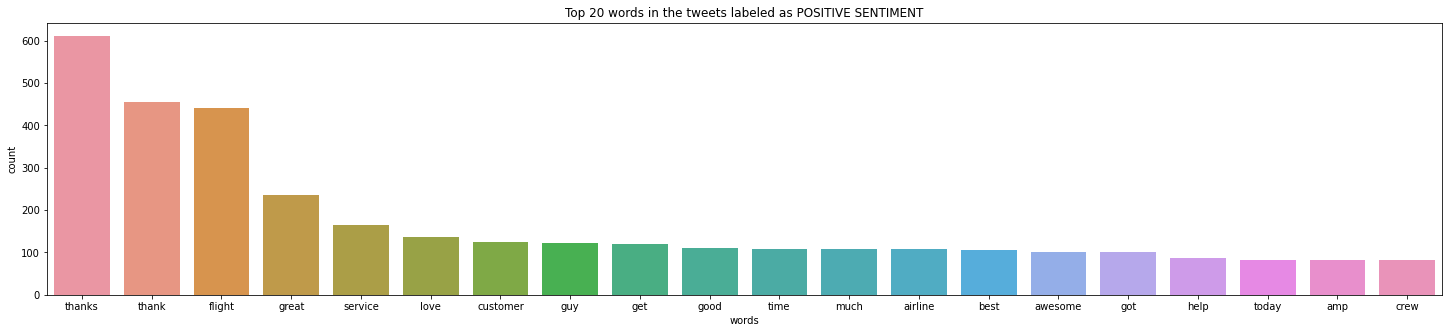

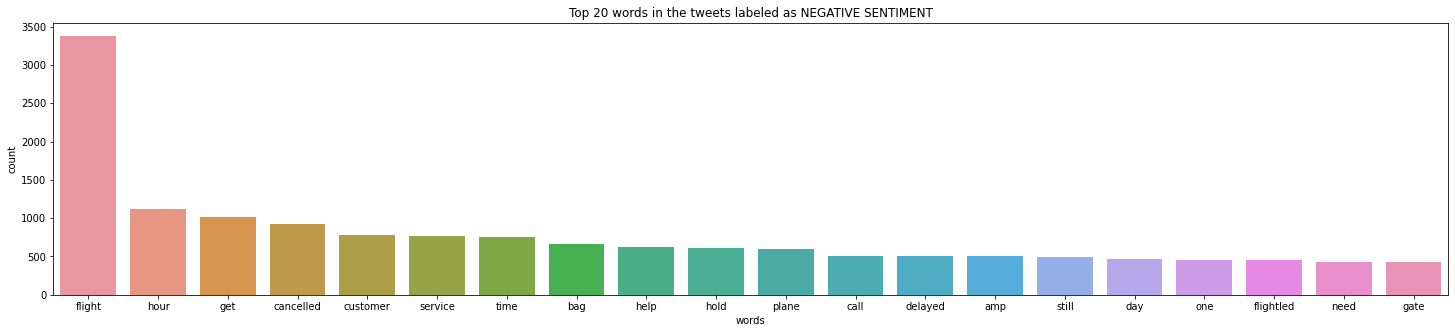

In [ ]:
list_pos_words = [ x for x in positive_words.split()]
freq_dis_pos = nltk.FreqDist(list_pos_words)
freq_dataframe = pd.DataFrame({'words': list(freq_dis_pos.keys()), 'count': list(freq_dis_pos.values())})
freq_dataframe = freq_dataframe.nlargest(columns="count", n = 20)
plt.figure(figsize=(25,5))
ax = sns.barplot(data=freq_dataframe, x= "words", y = "count")
ax.set(ylabel = 'count')
plt.title("Top 20 words in the tweets labeled as POSITIVE SENTIMENT")
plt.show()

list_neg_words = [ x for x in negative_words.split()]
freq_dis_pos = nltk.FreqDist(list_neg_words)
freq_dataframe = pd.DataFrame({'words': list(freq_dis_pos.keys()), 'count': list(freq_dis_pos.values())})
freq_dataframe = freq_dataframe.nlargest(columns="count", n = 20)
plt.figure(figsize=(25,5))
ax = sns.barplot(data=freq_dataframe, x= "words", y = "count")
ax.set(ylabel = 'count')
plt.title("Top 20 words in the tweets labeled as NEGATIVE SENTIMENT")
plt.show()

In [6]:
def sentiment2target(sentiment):
    return {
        'negative': 0,
        'neutral': 1,
        'positive' : 2
    }[sentiment]

y = df['airline_sentiment'].apply(sentiment2target)

In [7]:
# max_words = len(set(" ".join(df['clean_tweet']).split()))
max_len = df['clean_tweet'].apply(lambda x: len(x)).max()

max_words = 5000
max_words, max_len

(5000, 129)

In [8]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['clean_tweet'].values)
x_seq = tokenizer.texts_to_sequences(df['clean_tweet'].values)
x_seq = pad_sequences(x_seq,maxlen = max_len, padding='pre')
x_seq[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 119],
      dtype=int32)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_seq, y, test_size=0.2, random_state=42)
print("Training Data = ",len(x_train))
print("Testing Data = ",len(x_test))

Training Data =  11712
Testing Data =  2928


# ***Bidirectional LSTM Model***

In [15]:
lstm_model = Sequential()
lstm_model.add(Embedding(max_words, 128, input_length=max_len))
lstm_model.add(SpatialDropout1D(0.5))
lstm_model.add(Bidirectional(LSTM(200, dropout = 0.3, recurrent_dropout = 0.3 )))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(100, activation = 'relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(3, activation = 'softmax'))

In [16]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 129, 128)          640000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 129, 128)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 400)               526400    
_________________________________________________________________
dropout_4 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               40100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

In [17]:
lstm_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
len(x_train)

11712

In [18]:
lstm_history = lstm_model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
293/293 [==============================] - 262s 893ms/step - loss: 0.7400 - accuracy: 0.6828 - val_loss: 0.6153 - val_accuracy: 0.7516
Epoch 2/10
293/293 [==============================] - 260s 888ms/step - loss: 0.5356 - accuracy: 0.7875 - val_loss: 0.6084 - val_accuracy: 0.7520
Epoch 3/10
293/293 [==============================] - 261s 891ms/step - loss: 0.4447 - accuracy: 0.8271 - val_loss: 0.5858 - val_accuracy: 0.7751
Epoch 4/10
293/293 [==============================] - 259s 885ms/step - loss: 0.3835 - accuracy: 0.8523 - val_loss: 0.5680 - val_accuracy: 0.7738
Epoch 5/10
293/293 [==============================] - 260s 886ms/step - loss: 0.3363 - accuracy: 0.8761 - val_loss: 0.6205 - val_accuracy: 0.7746
Epoch 6/10
293/293 [==============================] - 258s 880ms/step - loss: 0.2985 - accuracy: 0.8881 - val_loss: 0.6039 - val_accuracy: 0.7751
Epoch 7/10
293/293 [==============================] - 259s 885ms/step - loss: 0.2689 - accuracy: 0.9014 - val_loss: 0.6781 -

In [21]:
lstm_test_score, lstm_test_acc = lstm_model.evaluate(x_test, y_test,verbose=1)
print('Test score:', lstm_test_score)
print('Test accuracy:', lstm_test_acc)
print()
lstm_train_score, lstm_train_acc = lstm_model.evaluate(x_train, y_train,verbose=1)
print('Training score:', lstm_train_score)
print('Training accuracy:', lstm_train_acc)

92/92 [==============================] - 5s 56ms/step - loss: 0.7659 - accuracy: 0.7661
Test score: 0.7659462094306946
Test accuracy: 0.7660518884658813

366/366 [==============================] - 22s 60ms/step - loss: 0.2554 - accuracy: 0.9191
Training score: 0.2553524971008301
Training accuracy: 0.9190573692321777


# ***Bidirectional GRU Model***

In [38]:
gru_model = Sequential()
gru_model.add(Embedding(max_words, 128, input_length=max_len))
gru_model.add(SpatialDropout1D(0.5))
gru_model.add(Bidirectional(GRU(200, dropout = 0.3, recurrent_dropout = 0.3 )))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(100, activation = 'relu'))
gru_model.add(Dropout(0.3))
gru_model.add(Dense(3, activation = 'softmax'))

In [39]:
gru_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 129, 128)          640000    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 129, 128)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 400)               396000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               40100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                

In [40]:
gru_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
gru_history = gru_model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
293/293 [==============================] - 241s 823ms/step - loss: 0.7394 - accuracy: 0.6882 - val_loss: 0.6252 - val_accuracy: 0.7431
Epoch 2/10
293/293 [==============================] - 242s 828ms/step - loss: 0.5225 - accuracy: 0.7947 - val_loss: 0.5764 - val_accuracy: 0.7712
Epoch 3/10
293/293 [==============================] - 240s 821ms/step - loss: 0.4412 - accuracy: 0.8270 - val_loss: 0.5893 - val_accuracy: 0.7670
Epoch 4/10
293/293 [==============================] - 240s 818ms/step - loss: 0.3747 - accuracy: 0.8578 - val_loss: 0.5854 - val_accuracy: 0.7674
Epoch 5/10
293/293 [==============================] - 242s 825ms/step - loss: 0.3394 - accuracy: 0.8718 - val_loss: 0.5980 - val_accuracy: 0.7704
Epoch 6/10
293/293 [==============================] - 241s 823ms/step - loss: 0.2959 - accuracy: 0.8852 - val_loss: 0.6480 - val_accuracy: 0.7678
Epoch 7/10
293/293 [==============================] - 240s 819ms/step - loss: 0.2606 - accuracy: 0.9013 - val_loss: 0.6965 -

In [42]:
gru_test_score, gru_test_acc = gru_model.evaluate(x_test, y_test,verbose=1)
print('Test score:', gru_test_score)
print('Test accuracy:', gru_test_acc)
print()
gru_train_score, gru_train_acc = gru_model.evaluate(x_train, y_train,verbose=1)
print('Training score:', gru_train_score)
print('Training accuracy:', gru_train_acc)

92/92 [==============================] - 6s 64ms/step - loss: 0.8086 - accuracy: 0.7640
Test score: 0.8085750937461853
Test accuracy: 0.7640027403831482

366/366 [==============================] - 29s 80ms/step - loss: 0.2553 - accuracy: 0.9223
Training score: 0.2552680969238281
Training accuracy: 0.9223018884658813


# ***Bidirectional LSTM with GloVe Embeddings***

In [28]:
index_of_words = tokenizer.word_index
print(type(index_of_words))

<class 'dict'>


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [30]:
!ls /content/gdrive/My\ Drive/Colab\ Files

glove.6B.100d.txt


In [31]:
glove_file = "glove.6B.100d.txt"
file_path = "/content/gdrive/My Drive/Colab Files/glove.6B.100d.txt"
f = open(file_path, encoding = "utf-8")
embedd_index = {}
for line in f:
    val = line.split()
    word = val[0]
    coff = np.asarray(val[1:],dtype = 'float')
    embedd_index[word] = coff

f.close()
print('Found %s word vectors.' % len(embedd_index))

Found 400000 word vectors.


In [32]:
index_of_words = tokenizer.word_index
print(len(index_of_words))

11403


In [33]:
embedding_matrix = np.zeros((len(index_of_words) + 1, 100))

for word,i in index_of_words.items():
    temp = embedd_index.get(word)
    if temp is not None:
        embedding_matrix[i] = temp

embedding_matrix.shape

(11404, 100)

In [34]:
embedd_layer = Embedding(len(index_of_words) + 1 , 100 , input_length = max_len , weights = [embedding_matrix])

In [44]:
glove_model = Sequential()
glove_model.add(embedd_layer)
glove_model.add(SpatialDropout1D(0.5))
glove_model.add(Bidirectional(GRU(200, dropout = 0.3, recurrent_dropout = 0.3 )))
glove_model.add(Dropout(0.2))
glove_model.add(Dense(100, activation = 'relu'))
glove_model.add(Dropout(0.3))
glove_model.add(Dense(3, activation = 'softmax'))

In [45]:
glove_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [46]:
glove_history = glove_model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
293/293 [==============================] - 241s 823ms/step - loss: 0.7896 - accuracy: 0.6734 - val_loss: 0.6428 - val_accuracy: 0.7324
Epoch 2/10
293/293 [==============================] - 241s 824ms/step - loss: 0.6633 - accuracy: 0.7324 - val_loss: 0.5742 - val_accuracy: 0.7576
Epoch 3/10
293/293 [==============================] - 241s 824ms/step - loss: 0.6166 - accuracy: 0.7467 - val_loss: 0.5569 - val_accuracy: 0.7674
Epoch 4/10
293/293 [==============================] - 242s 827ms/step - loss: 0.5685 - accuracy: 0.7667 - val_loss: 0.5320 - val_accuracy: 0.7751
Epoch 5/10
293/293 [==============================] - 242s 827ms/step - loss: 0.5372 - accuracy: 0.7830 - val_loss: 0.5260 - val_accuracy: 0.7870
Epoch 6/10
293/293 [==============================] - 239s 817ms/step - loss: 0.5105 - accuracy: 0.7933 - val_loss: 0.5241 - val_accuracy: 0.7828
Epoch 7/10
293/293 [==============================] - 240s 818ms/step - loss: 0.4849 - accuracy: 0.8050 - val_loss: 0.5361 -

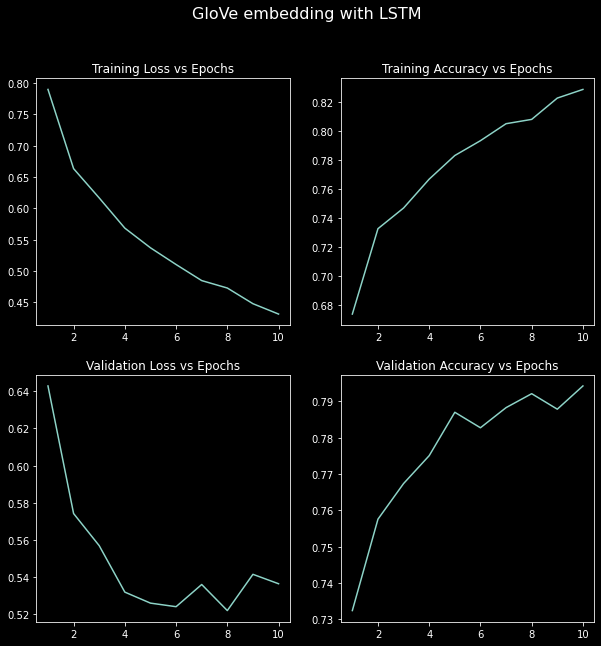

In [48]:
plt.style.use('dark_background')
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(x=np.arange(1, 11), y=glove_history.history.get('loss'), ax=ax[0, 0])
sns.lineplot(x=np.arange(1, 11), y=glove_history.history.get('accuracy'), ax=ax[0, 1])
sns.lineplot(x=np.arange(1, 11), y=glove_history.history.get('val_loss'), ax=ax[1, 0])
sns.lineplot(x=np.arange(1, 11), y=glove_history.history.get('val_accuracy'), ax=ax[1, 1])
ax[0, 0].set_title('Training Loss vs Epochs')
ax[0, 1].set_title('Training Accuracy vs Epochs')
ax[1, 0].set_title('Validation Loss vs Epochs')
ax[1, 1].set_title('Validation Accuracy vs Epochs')
plt.suptitle('GloVe embedding with LSTM',size=16)
plt.show()

In [50]:
glove_test_score, glove_test_acc = glove_model.evaluate(x_test, y_test,verbose = 1)
print('Test score:', glove_test_score)
print('Test accuracy:', glove_test_acc)
print()
glove_train_score, glove_train_acc = glove_model.evaluate(x_train, y_train,verbose = 1)
print('Training score:', glove_train_score)
print('Training accuracy:', glove_train_acc)

92/92 [==============================] - 6s 64ms/step - loss: 0.4991 - accuracy: 0.8033
Test score: 0.4990635812282562
Test accuracy: 0.8032786846160889

366/366 [==============================] - 29s 78ms/step - loss: 0.3672 - accuracy: 0.8537
Training score: 0.3672336935997009
Training accuracy: 0.8537397384643555


# ***Comparing different models***

   model     metric     score
0   lstm  train_acc  0.919057
1   lstm   test_acc  0.766052
2    gru  train_acc  0.922302
3    gru   test_acc  0.764003
4  glove  train_acc  0.853740
5  glove   test_acc  0.803279


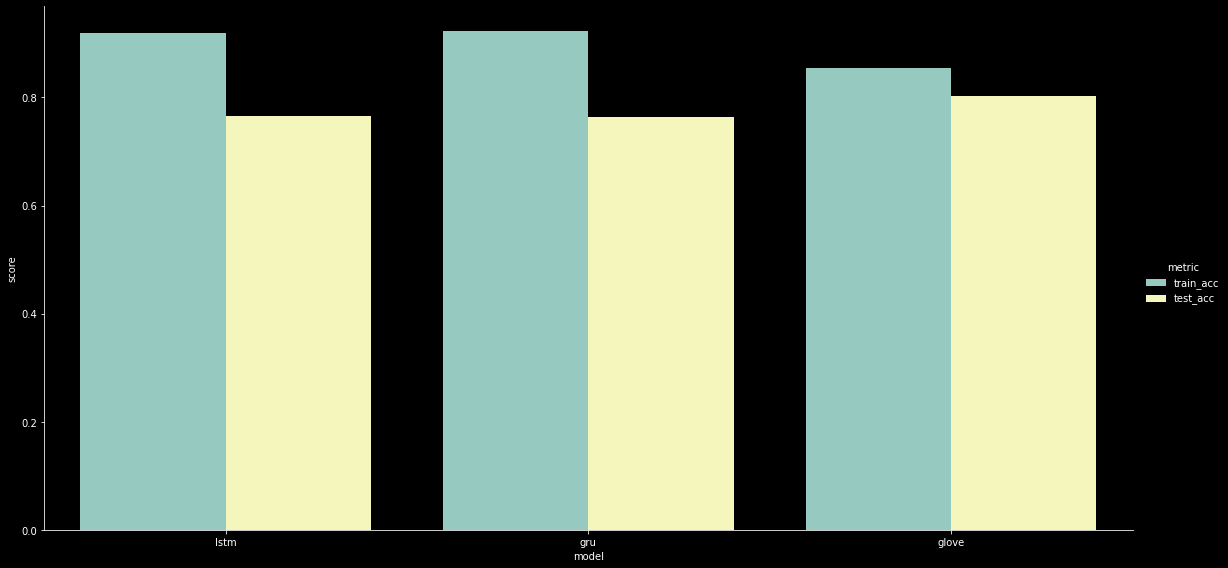

In [54]:
model_list = 2*["lstm"] + 2*["gru"] + 2*["glove"]
metric_list = 3*["train_acc", "test_acc"]
score_list = []

for i in range(len(model_list)):
  metric = model_list[i] + "_" + metric_list[i]
  score_list.append(vars()[metric])

metric_data = pd.DataFrame({
    "model": model_list,
    "metric": metric_list,
    "score": score_list
})
print(metric_data)
sns.catplot(x='model', y='score', hue='metric', kind="bar", data=metric_data, height=8, aspect=2)

In [53]:
# Saving the models
lstm_model.save('lstm_model.h5')
gru_model.save('gru_model.h5')
glove_model.save('glove_model.h5')